In [1]:
import os
from os.path import join
import re
import pickle

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from vowpalwabbit.DFtoVW import DFtoVW
from vowpalwabbit.pyvw import vw

# Graphical
SUPTITLE_FONTSIZE = 20
SUPTITLE_FONTWEIGHT = "bold"
TITLE_FONTSIZE = 15

In [2]:
feature_names =["Num token","Num char","Avg word length","Num ADJ","Num ADP","Num ADV","Num AUX","Num CCONJ","Num DET","Num INTJ","Num NOUN","Num NUM","Num PART","Num PRON","Num PROPN","Num PUNCT","Num SCONJ","Num SYM","Num VERB","Num X","Num LOC","Num MISC","Num ORG","Num PER","Num Abbr=Yes","Num Case=Acc","Num Case=Nom","Num Definite=Def","Num Definite=Ind","Num Degree=Cmp","Num Degree=Pos","Num Degree=Sup","Num Foreign=Yes","Num Gender=Fem","Num Gender=Masc","Num Gender=Neut","Num Mood=Imp","Num Mood=Ind","Num NumForm=Digit","Num NumForm=Word","Num NumType=Card","Num NumType=Mult","Num NumType=Ord","Num Number=Plur","Num Number=Sing","Num Person=1","Num Person=2","Num Person=3","Num Polarity=Neg","Num Poss=Yes","Num PronType=Art","Num PronType=Dem","Num PronType=Int","Num PronType=Prs","Num PronType=Rel","Num Reflex=Yes","Num Tense=Past","Num Tense=Pres","Num VerbForm=Fin","Num VerbForm=Ger","Num VerbForm=Inf","Num VerbForm=Part","Num Voice=Pass","Num Style=Expr","Num NumForm=Roman","Num Mood=Cnd","Num Mood=Sub","Num Number[psor]=Plur","Num Number[psor]=Sing","Num Person[psor]=1","Num Person[psor]=2","Num Person[psor]=3","Num PronType=Exc","Num PronType=Ind","Num PronType=Neg","Num Tense=Fut","Num Tense=Imp","Num Typo=Yes","Num Case=Dat","Num Case=Gen","Num Gender[psor]=Masc,Neut","Num Animacy=Anim","Num Animacy=Inan","Num Aspect=Imp","Num Aspect=Perf","Num Case=Ins","Num Case=Loc","Num Variant=Short","Num VerbForm=Conv","Num Voice=Act","Num Voice=Mid","Num AdpType=Comprep","Num AdpType=Prep","Num AdpType=Voc","Num Case=Voc","Num ConjType=Oper","Num Gender=Fem,Masc","Num Gender=Fem,Neut","Num Gender=Masc,Neut","Num Gender[psor]=Fem","Num Gender[psor]=Masc","Num Hyph=Yes","Num NameType=Com","Num NameType=Geo","Num NameType=Giv","Num NameType=Nat","Num NameType=Sur","Num NumType=Frac","Num NumType=Sets","Num NumValue=1","Num NumValue=1,2,3","Num Number=Dual","Num Number=Plur,Sing","Num Polarity=Pos","Num PrepCase=Npr","Num PrepCase=Pre","Num PronType=Emp","Num PronType=Int,Rel","Num PronType=Tot","Num Style=Arch","Num Style=Coll",
        ]
files = sorted(glob("./data/wmt_2020/*.pkl"))
features = []
labels = []
indexes = []
for file in files:
    with open(file, 'rb') as handle:
        b = pickle.load(handle)
    features.append(b['target-source'])
    labels.append(b['severity'])
    indexes.append(int(file.rsplit(os.sep, 1)[-1].split(".")[0]))
features = np.concatenate(features, axis=0)
labels = np.vstack(labels)
indexes = np.vstack(indexes)
data = np.concatenate([indexes, features, labels], axis=1)

df = pd.DataFrame(data, columns=['sample_id']+feature_names+["label"])
print(df.shape)
df.head()
df[feature_names] = df[feature_names].astype(float)

(79020, 123)


In [3]:
df.set_index('sample_id', inplace=True)

In [4]:
df[df == "nan"] = np.nan
df = df[df['label'].notna()]

In [5]:
## Combining neutral with no-error
df.label = df.label.replace({
    "no-error":"Neutral",
    "No-error":"Neutral",
    "word order": "Minor",
}).values.reshape(-1,1)

In [6]:
df.label = df.label.replace({
                                "Neutral": 1,
                                "Minor": 2, 
                                "Major":3, 
                            }).values.reshape(-1,1)
df[['label']] =  df[['label']].astype(int)
df[df == "nan"] = np.nan

<AxesSubplot:ylabel='Count'>

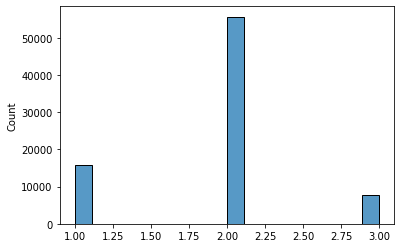

In [7]:
sns.histplot(df.label.values)

In [39]:
df.to_csv("data/wmt_2020_features.csv", index=True)

In [7]:
import numpy as np
import string
NS_LIST = list(string.ascii_lowercase) + list(string.ascii_uppercase)

X = df[feature_names].values
y = df[['label']].values.reshape(-1,)
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, random_state=42, stratify=y)

In [8]:
np.save("./data/X_train.npy", X_train)
np.save("./data/y_train.npy", y_train)
np.save("./data/X_test.npy", X_test)
np.save("./data/y_test.npy", y_test)

In [75]:
X_train = np.load("./data/X_train.npy")
y_train = np.load("./data/y_train.npy")
X_test = np.load("./data/X_test.npy")
y_test = np.load("./data/y_test.npy")

## Prepare the datasert in the vowpalwabbit format

In [26]:
def default_label_str(y):
    return f"{y}"

def default_feature_str(x:list):
    return " ".join([f"{j}:{x[j]}" for j in range(len(x))])

def get_training_example(x,y, label_str_fn = default_label_str, feature_str_fn = default_feature_str):
    return f"{label_str_fn(y)} | {feature_str_fn(x)}"

def get_test_example(x, label_str_fn = default_label_str, feature_str_fn = default_feature_str):
    return f"| {feature_str_fn(x)}"

def get_vw_examples(X, y, label_str_fn = default_label_str, feature_str_fn = default_feature_str):
    vw_examples = []
    for i in range(X.shape[0]):
        vw_examples.append(get_training_example(X[i], y[i], label_str_fn = label_str_fn, feature_str_fn = feature_str_fn))
    return vw_examples

    

In [27]:
vw_examples= get_vw_examples(X_train, y_train)

## Set up the online learning loop

In [28]:
from sklearn.metrics import mean_squared_error
import random
def online_learning_loop(iter_num, vw_examples, vw_alg, seed=0):
    """Implements the online learning loop.
    """
    iter_num = len(vw_examples)
    print('Online learning for', iter_num, 'steps...')
    random.seed(seed)
    random.shuffle(vw_examples)
    loss_list = []
    for i in range(iter_num):
        vw_x = vw_examples[i]
        y_true = float(vw_examples[i].split('|')[0])
        # predict step
        y_pred = vw_alg.predict(vw_x)
        # learn step
        vw_alg.learn(vw_x)
        # calculate one step loss
        loss = mean_squared_error([y_pred], [y_true])
        loss_list.append(loss)
    return loss_list

max_iter_num = len(vw_examples)

## Vanilla Vowpal Wabbit (VW)
Create and run a vanilla vowpal wabbit learner.

In [29]:
from vowpalwabbit import pyvw
''' create a vanilla vw instance '''
vanilla_vw = pyvw.vw('--quiet', loss_function= 'squared')

# online learning with vanilla VW
loss_list_vanilla = online_learning_loop(max_iter_num, vw_examples, vanilla_vw)
print('Final progressive validation loss of vanilla vw:', sum(loss_list_vanilla)/len(loss_list_vanilla))

Online learning for 52943 steps...
Final progressive validation loss of vanilla vw: 0.5768117603318698


In [33]:
y_pred = []
for i in range(X_test.shape[0]):
    ex = get_test_example(X_test[i])
    y_pred.append(vanilla_vw.predict(ex))

In [35]:
from sklearn.metrics import  r2_score, mean_absolute_error , mean_squared_error
print(f"R2  : {r2_score(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2  : 0.017791950120346067
MAE : 0.4572558777895598
MSE: 0.5731291643000318


In [9]:
df_input = pd.read_csv(
    "./wmt-mqm-human-evaluation/newstest2020/ende/mqm_newstest2020_ende.tsv", sep="\t"
)

In [21]:
{i:v for i,v in enumerate(sorted(df_input.category.unique()))}

{0: 'Accuracy/Addition',
 1: 'Accuracy/Mistranslation',
 2: 'Accuracy/Omission',
 3: 'Accuracy/Untranslated text',
 4: 'Fluency/Character encoding',
 5: 'Fluency/Grammar',
 6: 'Fluency/Inconsistency',
 7: 'Fluency/Punctuation',
 8: 'Fluency/Register',
 9: 'Fluency/Spelling',
 10: 'Locale convention/Address format',
 11: 'Locale convention/Currency format',
 12: 'Locale convention/Date format',
 13: 'Locale convention/Time format',
 14: 'Non-translation!',
 15: 'Other',
 16: 'Other/-',
 17: 'Style/Awkward',
 18: 'Terminology/Inappropriate for context',
 19: 'Terminology/Inconsistent use of terminology',
 20: 'no-error'}

In [17]:
df_2021 = pd.read_csv(
    "./wmt-mqm-human-evaluation/newstest2021/ende/mqm-newstest2021_ende.tsv",
    sep="\t",
    on_bad_lines="skip",
)

In [20]:
{i:v for i,v in enumerate(sorted(df_2021.category.unique()))}

{0: 'Accuracy/Addition',
 1: 'Accuracy/Mistranslation',
 2: 'Accuracy/Omission',
 3: 'Accuracy/Untranslated',
 4: 'Fluency/Display',
 5: 'Fluency/Grammar',
 6: 'Fluency/Inconsistency',
 7: 'Fluency/Punctuation',
 8: 'Fluency/Register',
 9: 'Fluency/Spelling',
 10: 'Locale_convention/Currency',
 11: 'Locale_convention/Date',
 12: 'Locale_convention/Time',
 13: 'Major',
 14: 'Minor',
 15: 'No-error',
 16: 'Source_error',
 17: 'Style/Awkward',
 18: 'Terminology/Inappropriate',
 19: 'Terminology/Inconsistent'}

In [27]:
{i:k for i,k in enumerate(sorted(list(set(list(df_2021.category.unique()) + list(df_input.category.unique())))))}


{0: 'Accuracy/Addition',
 1: 'Accuracy/Mistranslation',
 2: 'Accuracy/Omission',
 3: 'Accuracy/Untranslated',
 4: 'Accuracy/Untranslated text',
 5: 'Fluency/Character encoding',
 6: 'Fluency/Display',
 7: 'Fluency/Grammar',
 8: 'Fluency/Inconsistency',
 9: 'Fluency/Punctuation',
 10: 'Fluency/Register',
 11: 'Fluency/Spelling',
 12: 'Locale convention/Address format',
 13: 'Locale convention/Currency format',
 14: 'Locale convention/Date format',
 15: 'Locale convention/Time format',
 16: 'Locale_convention/Currency',
 17: 'Locale_convention/Date',
 18: 'Locale_convention/Time',
 19: 'Major',
 20: 'Minor',
 21: 'No-error',
 22: 'Non-translation!',
 23: 'Other',
 24: 'Other/-',
 25: 'Source_error',
 26: 'Style/Awkward',
 27: 'Terminology/Inappropriate',
 28: 'Terminology/Inappropriate for context',
 29: 'Terminology/Inconsistent',
 30: 'Terminology/Inconsistent use of terminology',
 31: 'no-error'}